<a href="https://colab.research.google.com/github/Lee-Minsoo-97/Sentiment-Classification-using-ML/blob/main/LA2_Lee_Minsoo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Classification with Machine Learning Approache

Minsoo Lee\
1234090054\
01/27/2025




In [3]:
!pip install -q vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 7.7 MB/s eta 0:00:00


In [4]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [52]:
# Import
import numpy as np
import pandas as pd
import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# Load data
path = "/content/drive/MyDrive/Colab Notebooks/Unstructed data/restaurant_reviews_az.csv"
review_df = pd.read_csv(path)

In [7]:
# Extract first 10000 rows
review_df = review_df.head(10000)
summary = review_df.info()
#print(summary)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_id    10000 non-null  object
 1   user_id      10000 non-null  object
 2   business_id  10000 non-null  object
 3   stars        10000 non-null  int64 
 4   useful       10000 non-null  int64 
 5   funny        10000 non-null  int64 
 6   cool         10000 non-null  int64 
 7   text         10000 non-null  object
 8   date         10000 non-null  object
 9   Sentiment    10000 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 781.4+ KB


In [8]:
#Conduct necessary data processing
review_df=review_df[['text']]

##  Conducting necessary data processing
- Normalize (lowercase and removing stop words)\
Stop words are such as words like “um,” “like,” and “you know” are filler words that carry little information.

In [9]:
# Conduct necessary data processing

nlp = spacy.load("en_core_web_lg")
def normalize(review, lowercase, remove_stopwords):
    if lowercase:
        review = review.lower()
    doc = nlp(review)
    lemmatized = list()
    for token in doc:
        if not remove_stopwords or (remove_stopwords and not token.is_stop):
            lemmatized.append(token.lemma_)
    return " ".join(lemmatized)


review_df['processed'] = review_df['text'].apply(normalize, lowercase=True, remove_stopwords=True)

In [10]:
review_df.head()

,text,processed
0,"OK, the hype about having Hatch chili in your ...","ok , hype have hatch chili burger overrate . o..."
1,Pandemic pit stop to have an ice cream.... onl...,pandemic pit stop ice cream .... plain sundae ...
2,I was lucky enough to go to the soft opening a...,lucky soft opening let tell ... good . beer wi...
3,I've gone to claim Jumpers all over the US and...,go claim jumper disappoint location different ...
4,"If you haven't been to Maynard's kitchen, it'...","maynard kitchen , time ! hope dinner , sure ..."


In [11]:
# Initialize the Vader Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to compute sentiment scores
def get_vader_sentiment(text):
    scores = analyzer.polarity_scores(text)
    return scores['compound']  # Compound score represents overall sentiment

# Apply Vader Sentiment to the 'text' column
review_df['vader_sentiment'] = review_df['text'].apply(get_vader_sentiment)

# Classify sentiments (Thresholds: Positive, Neutral, Negative)
def classify_sentiment(score):
    if score >= 0.05:
        return 1  # Positive
    elif score <= -0.05:
        return -1  # Negative
    else:
        return 0  # Neutral

# Assign sentiment labels based on Vader scores
review_df['vader_label'] = review_df['vader_sentiment'].apply(classify_sentiment)

In [12]:
review_df

,text,processed,vader_sentiment,vader_label
0,"OK, the hype about having Hatch chili in your ...","ok , hype have hatch chili burger overrate . o...",0.9860,1
1,Pandemic pit stop to have an ice cream.... onl...,pandemic pit stop ice cream .... plain sundae ...,0.5877,1
2,I was lucky enough to go to the soft opening a...,lucky soft opening let tell ... good . beer wi...,0.9781,1
3,I've gone to claim Jumpers all over the US and...,go claim jumper disappoint location different ...,0.9327,1
4,"If you haven't been to Maynard's kitchen, it'...","maynard kitchen , time ! hope dinner , sure ...",0.9823,1
...,...,...,...,...
9995,Found this tepanyaki restaurant a few years ag...,find tepanyaki restaurant year ago come fix . ...,0.8650,1
9996,This was our first time in Tucson. We decided ...,time tucson . decide stop real authentic mexic...,0.6306,1
9997,We had a birthday dinner reservation at 8:00 w...,birthday dinner reservation 8:00 seat 8:40 par...,0.6705,1
9998,Took my parents to dinner here for my Dads bir...,take parent dinner dad birthday . walk place f...,0.9623,1


##Machine Learning Approaches with Scikit Learn
 - CountVectorizer : https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
 - Classification Report: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
 - Naive Bayes: https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes


**We are using CounterVecorizer for this excercise.**

### Prepare the training and test sets (80% Training / 20% Testing)

In [36]:
# Define features (processed review text) and labels (actual sentiment labels)
X = review_df['processed']  # Processed text data
y = review_df['vader_label']  # sentiment

In [37]:
# Split dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [38]:
# Apply CountVectorizer (Bag of Words) with max_features=1000
vectorizer = CountVectorizer(max_features=1000)
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

In [39]:
# Display dataset size and feature shape
print(f"Training Set: {X_train.shape[0]} samples")
print(f"Test Set: {X_test.shape[0]} samples")
print(f"BoW Training Data Shape: {X_train_bow.shape}")
print(f"BoW Test Data Shape: {X_test_bow.shape}")

Training Set: 8000 samples
Test Set: 2000 samples
BoW Training Data Shape: (8000, 1000)
BoW Test Data Shape: (2000, 1000)


In [40]:
#Code sell 4
#Processed data statistics (both test and train data)
processed_df = review_df[['processed']]
#prcessed_df.head()

In [22]:
# variables to store term statistics
num_of_comments = 0
unique_word = set() # using the set-type variable since it does not allow duplicates > able to count the number of unique words
num_of_token_per_comment = [] # using the list-type varailbe since we want to measure corpus-level statistics (e.g., avg, max, min, median, etc.)
num_of_token_per_comment_without_stop_words = []
total_number_of_tokens = 0 # in a corpus
unique_user = set() # using the set-type variable since it does not allow duplicates > able to count the number of unique users
date_list = [] # able to measure the number of comments by day, week, etc.
vote_count = 0
unique_submission = set() # using the set-type variable since it does not allow duplicates > able to count the number of unique submissions

In [27]:
for index, row in processed_df.iterrows():
    text = row["processed"]
    doc = nlp(text)
    num_of_comments += 1

    # statistics regarding words
    num_of_tokens = len(doc)
    total_number_of_tokens += num_of_tokens
    token_count_without_stop_words = 0

    for token in doc:
        if token.is_stop is True:
            pass
        else:
            unique_word.add(str(token).lower())
            token_count_without_stop_words += 1

    num_of_token_per_comment.append(num_of_tokens)
    num_of_token_per_comment_without_stop_words.append(token_count_without_stop_words)

In [29]:
# statistics
print("Number of comments:", num_of_comments)
print("Number of unique words:", len(unique_word))
print("Total number of words in the corpus:", total_number_of_tokens)
print("Average number of words in comments:", np.mean(np.asarray(num_of_token_per_comment)))
print("Average number of words in comments without stop words:", np.mean(np.asarray(num_of_token_per_comment_without_stop_words)))
print("Maximum number of words in comments:", np.max(np.asarray(num_of_token_per_comment)))
print("Maximum number of words in comments without stop words:", np.max(np.asarray(num_of_token_per_comment_without_stop_words)))
print("Minimum number of words in comments:", np.min(np.asarray(num_of_token_per_comment)))
print("Minimum number of words in comments without stop words:", np.min(np.asarray(num_of_token_per_comment_without_stop_words)))
print("Median number of words in comments:", np.median(np.asarray(num_of_token_per_comment)))
print("Median number of words in comments without stop words:", np.median(np.asarray(num_of_token_per_comment_without_stop_words)))

Number of comments: 10000
Number of unique words: 15420
Total number of words in the corpus: 516694
Average number of words in comments: 51.6694
Average number of words in comments without stop words: 50.4272
Maximum number of words in comments: 603
Maximum number of words in comments without stop words: 591
Minimum number of words in comments: 4
Minimum number of words in comments without stop words: 4
Median number of words in comments: 37.0
Median number of words in comments without stop words: 36.0


##Naive Bayes Classification

- Apply naïve Bayes classification to train dataset.
- Report on performance of the model.

In [41]:
#Training the model
from sklearn.naive_bayes import MultinomialNB
MNB = MultinomialNB()
MNB.fit(X_train_bow, y_train)

MultinomialNB()

In [42]:
#Evaluate the performance of the model
from sklearn import metrics
predicted = MNB.predict(X_test_bow)
performance = metrics.classification_report(y_test,predicted, target_names= ['-1','0', '1'])
print(performance)

              precision    recall  f1-score   support

          -1       0.54      0.74      0.62       293
           0       0.20      0.06      0.09        35
           1       0.95      0.90      0.92      1672

    accuracy                           0.86      2000
   macro avg       0.56      0.56      0.54      2000
weighted avg       0.87      0.86      0.86      2000



##Support Vector Machines (SVM) classification

- Apply support vector machines (SVM) classification to train dataset.
- Report on performance of the model.

In [47]:
#train the model
clf = svm.SVC()
clf.fit(X_train_bow, y_train)

SVC()

In [48]:
#report
predicted = clf.predict(X_test_bow)
performance = metrics.classification_report(y_test,predicted, target_names= ['-1','0', '1'])
print(performance)


              precision    recall  f1-score   support

          -1       0.74      0.51      0.60       293
           0       0.00      0.00      0.00        35
           1       0.91      0.98      0.94      1672

    accuracy                           0.89      2000
   macro avg       0.55      0.49      0.51      2000
weighted avg       0.87      0.89      0.87      2000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## TF-IDF

In [50]:
token = RegexpTokenizer(r'[a-zA-Z]+')
vectorizer = TfidfVectorizer(stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize, max_features = 800)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_train_tfidf.shape

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(8000, 800)

In [51]:
df = pd.DataFrame(X_train_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
df.head()

,able,absolutely,accommodate,actually,add,addition,ago,ahead,al,allow,...,wrap,write,wrong,year,yelp,yes,yesterday,young,yum,yummy
0,0.0,0.0,0.0,0.305706,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.158011,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
# Initialize Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')  # Added class_weight to handle imbalance

# Train the model
lr_model.fit(X_train_tfidf, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [54]:
# Predict on the test data
X_test_tfidf = vectorizer.transform(X_test)
y_pred = lr_model.predict(X_test_tfidf)

Logistic Regression Accuracy: 84.90%

Classification Report:
               precision    recall  f1-score   support

Negative (-1)       0.53      0.83      0.65       293
  Neutral (0)       0.08      0.14      0.10        35
 Positive (1)       0.98      0.87      0.92      1672

     accuracy                           0.85      2000
    macro avg       0.53      0.61      0.56      2000
 weighted avg       0.90      0.85      0.87      2000



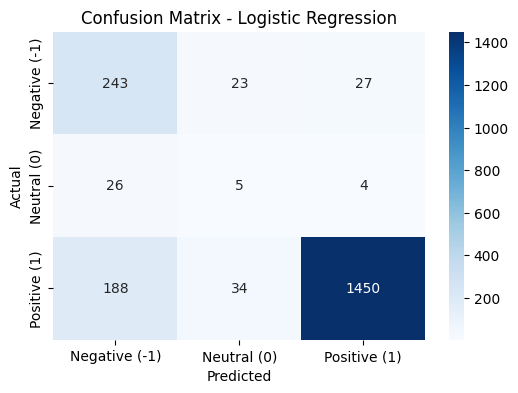

In [55]:
# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy * 100:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative (-1)', 'Neutral (0)', 'Positive (1)']))

# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative (-1)', 'Neutral (0)', 'Positive (1)'],
            yticklabels=['Negative (-1)', 'Neutral (0)', 'Positive (1)'])
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Performance Overview of Sentiment Analysis Models

\
\begin{array}{|l|c|c|c|c|}
\hline
\textbf{Model} & \textbf{Accuracy (\%)} & \textbf{Negative F1} & \textbf{Neutral F1} & \textbf{Positive F1} \\
\hline
\text{VADER (Lexicon-Based)}         & 86 & 0.60 & 0.20 & 0.90 \\
\text{Naive Bayes}                    & 86 & 0.62 & 0.09 & 0.92 \\
\text{SVM}                            & 89 & 0.60 & 0.00 & 0.94 \\
\text{Logistic Regression (TF-IDF)}   & 85 & 0.65 & 0.10 & 0.92 \\
\hline
\end{array}


\
\
**Best Model for Positive Reviews:**
- SVM with an F1-score of 0.94 excels in detecting positive sentiments.


**Best Model for Negative Reviews:**
- Logistic Regression (F1-score 0.65) offers balanced recall and precision.


**Worst Performance for Neutral Sentiment:**
- All models struggle, but Naive Bayes and Logistic Regression slightly outperform SVM.


**Lexicon-Based vs. ML Models:**
- Lexicon-based methods (VADER) are fast and easy but lack context-awareness.
- Machine learning models like SVM and Logistic Regression are better at capturing complex patterns but require proper handling of class imbalance.

In [56]:
# Input 2 Reviews
input_reviews = [
    "The service is good, but location is hard to find. Sanitation is not very good with old facilities. Food served tasted extremely fishy, making us difficult to even finish it.",
    "The restaurant is definitely one of my favorites and of my family as well. I was especially impressed with my visit a few days ago. The place is clean, and you just need to wait for fewer than 10 minutes to get food served. And of course, the food is absolutely delicious!",
    "I appreciated the friendly staff. The food was good, not amazing. The service was not prompt but almost acceptable. A reliable spot for a regular meal, but nothing extraordinary."
]

In [57]:
# Transform the input reviews using the existing TF-IDF vectorizer
input_tfidf = vectorizer.transform(input_reviews)

# Predict sentiment using the trained Logistic Regression model
predicted_sentiments = lr_model.predict(input_tfidf)

In [58]:
# Display predictions
for review, sentiment in zip(input_reviews, predicted_sentiments):
    sentiment_label = {1: "Positive", 0: "Neutral", -1: "Negative"}.get(sentiment, "Unknown")
    print(f"Review: {review}\nPredicted Sentiment: {sentiment_label}\n")

Review: The service is good, but location is hard to find. Sanitation is not very good with old facilities. Food served tasted extremely fishy, making us difficult to even finish it.
Predicted Sentiment: Negative

Review: The restaurant is definitely one of my favorites and of my family as well. I was especially impressed with my visit a few days ago. The place is clean, and you just need to wait for fewer than 10 minutes to get food served. And of course, the food is absolutely delicious!
Predicted Sentiment: Positive

Review: I appreciated the friendly staff. The food was good, not amazing. The service was not prompt but almost acceptable. A reliable spot for a regular meal, but nothing extraordinary.
Predicted Sentiment: Positive



In [59]:
#print(lr_model)

LogisticRegression(class_weight='balanced', max_iter=1000)


In [60]:
# Get probabilities for each class
predicted_probabilities = lr_model.predict_proba(input_tfidf)

# Display predictions with probabilities
for review, sentiment, probs in zip(input_reviews, predicted_sentiments, predicted_probabilities):
    sentiment_label = {1: "Positive", 0: "Neutral", -1: "Negative"}.get(sentiment, "Unknown")
    probability_dict = {label: round(prob, 4) for label, prob in zip(lr_model.classes_, probs)}

    print(f"Review: {review}")
    print(f"Predicted Sentiment: {sentiment_label}")
    print(f"Class Probabilities: {probability_dict}")
    print("-" * 80)

Review: The service is good, but location is hard to find. Sanitation is not very good with old facilities. Food served tasted extremely fishy, making us difficult to even finish it.
Predicted Sentiment: Negative
Class Probabilities: {-1: 0.6168, 0: 0.0142, 1: 0.369}
--------------------------------------------------------------------------------
Review: The restaurant is definitely one of my favorites and of my family as well. I was especially impressed with my visit a few days ago. The place is clean, and you just need to wait for fewer than 10 minutes to get food served. And of course, the food is absolutely delicious!
Predicted Sentiment: Positive
Class Probabilities: {-1: 0.0755, 0: 0.0186, 1: 0.9059}
--------------------------------------------------------------------------------
Review: I appreciated the friendly staff. The food was good, not amazing. The service was not prompt but almost acceptable. A reliable spot for a regular meal, but nothing extraordinary.
Predicted Sentim

I have worked with ChatGPT.

In [61]:
!pip install jupyter
!pip install nbconvert
!jupyter nbconvert '/content/drive/MyDrive/Colab Notebooks/Unstructed data/LA2_Lee_Minsoo.ipynb' --to html

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 111.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.8/385.8 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 6.1.12
    Uninstalling jupyter-client-6.1.12:
      Successfully uninstalled jupyter-client-6.1.12
  Attempting uninstall: ipykernel
    Found existing installation: ipykernel 5.5.6
    Uninstalling ipykernel-5.5.6:
      Successfully uninstalled ipykernel-5.5.6
  Attempting un